# From Hollywood to Bollywood, an analysis of movie industries across time.

---

In [53]:
# Add local python scripts to path
import sys
sys.path.append('../src')
import load
import clean
import aggregate
import plot

In [54]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
# Linked to data collection
import imdb
from bs4 import BeautifulSoup
import requests
import re

In [56]:
# For the NLP 
import sklearn
import sklearn.model_selection
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from fast_pagerank import pagerank

## 1. Load the data in dataframes

In [57]:
characters_raw = load.character_metadata()
movies_raw = load.movie_metadata()

In [58]:
ncountries_raw = aggregate.ncountries(movies_raw)
nmovies_raw = aggregate.nmovies(movies_raw)
ncharacters_raw = aggregate.ncharacters(characters_raw)
nactors_raw = aggregate.nactors(characters_raw)
print('Finished loading:')
print(f'- Number of countries:  {ncountries_raw}')
print(f'- Number of movies:     {nmovies_raw}')
print(f'- Number of characters: {ncharacters_raw}')
print(f'- Number of actors:     {nactors_raw}')

Finished loading:
- Number of countries:  147
- Number of movies:     81741
- Number of characters: 450669
- Number of actors:     135760


## 2. Clean up the data

### 2.1 Filtering countries of interest

To make comparisons between movies of different countries we assume that each movie comes from  a single country.
This is not always the case, we therefore drop all movies that come from multiple countries.

In [59]:
movies_unique = clean.filter_unique_countries(movies_raw)
nmovies_unique = aggregate.nmovies(movies_unique)
print(f'Dropped {nmovies_raw - nmovies_unique} movies coming from multiple countries, {nmovies_unique} movies remaining.')

Dropped 17372 movies coming from multiple countries, 64369 movies remaining.


We are only interested in the largest movie industries of the world (China, India, US, UK, Japan, France, South Korea). [SOURCE NEEDED]
To have meaningful comparisons we want to use enough movies from each of the country, let's say more than a 1000.

In [60]:
aggregate.top_countries_nmovies(movies_unique)

,Wikipedia_Movie_ID
Movie_Countries,
United States of America,30300
India,8240
United Kingdom,5343
Japan,2242
France,1853
Italy,1730
Canada,1342
Argentina,1266
Hong Kong,850


As we see above, we don't have enough movies for China and South Korea, this study will therefore only focus on US, India, UK, Japan and France.

In [61]:
countries_of_interest = ['United States of America', 'India', 'United Kingdom', 'Japan', 'France']
movies_filtered = clean.keep_countries(movies_unique, countries_of_interest)
nmovies_filtered = aggregate.nmovies(movies_filtered)
print(f'Dropped {nmovies_unique - nmovies_filtered} movies, {nmovies_filtered} movies remaining.')

Dropped 16391 movies, 47978 movies remaining.


Now we only keep the characters that come from these countries and add the country as a new column.

In [62]:
characters_filtered = clean.add_countries_to_characters(characters_raw, movies_filtered)
ncharacters_filtered = aggregate.ncharacters(characters_filtered)
print(f'Dropped {ncharacters_raw - ncharacters_filtered} characters, {ncharacters_filtered} characters remaining.')

Dropped 154098 characters, 296571 characters remaining.


As we can see the country of the movie of each character is now added as an extra column.

In [63]:
characters_filtered[['Character_Name', 'Movie_Countries']].head(5)

,Character_Name,Movie_Countries
0,Akooshay,United States of America
1,Lieutenant Melanie Ballard,United States of America
2,Desolation Williams,United States of America
3,Sgt Jericho Butler,United States of America
4,Bashira Kincaid,United States of America


Our cleaning is done, we see that while keeping 3% of the countries we keep around 60% of our original dataset.

In [64]:
movies = movies_filtered.reset_index().copy()
characters = characters_filtered.reset_index().copy()

ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
ncharacters = aggregate.ncharacters(characters)
nactors = aggregate.nactors(characters)
print('Finished filtering countries of interest:')
print(f'- Number of countries:  {ncountries} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of characters: {ncharacters} ({ncharacters / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors} ({nactors / nactors_raw:.1%})')

Finished filtering countries of interest:
- Number of countries:  5 (3.4%)
- Number of movies:     47978 (58.7%)
- Number of characters: 296571 (65.8%)
- Number of actors:     81896 (60.3%)


### 2.2 Filtering periods

We convert our columns corresponding to dates from string to datetime for easier manipulation and drop unspecified dates.

In [65]:
characters_parsed = clean.parse_dates(characters)
movies_parsed = clean.parse_dates(movies)

ncharacters_parsed = aggregate.ncharacters(characters_parsed)
nmovies_parsed = aggregate.nmovies(movies_parsed)

print(f'Dropped {ncharacters - ncharacters_parsed} characters, {ncharacters_parsed} characters remaining.')
print(f'Dropped {nmovies - nmovies_parsed} movies, {nmovies_parsed} movies remaining.')

Dropped 4257 characters, 292314 characters remaining.
Dropped 2477 movies, 45501 movies remaining.


As a sanity check we make sure that the movie release dates are the same in the movies and characters tables.

In [66]:
ndifferences = clean.date_differences(movies_parsed, characters_parsed)
print(f'There are {ndifferences} differences between the movie and character dates.')

There are 0 differences between the movie and character dates.


We need a good representation of movies of each country over time.
We visualize the number of movies over time and the fraction from each country to select a representative time interval.

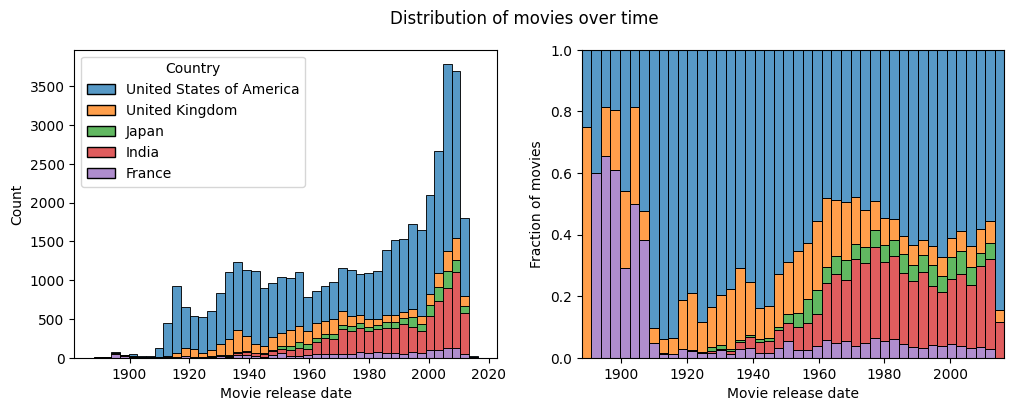

In [67]:
plot.movie_distribution_over_time(movies_parsed)

Based on this visualization we select movies from 1950 to 2013 for our analysis, and see that movies from each country are sufficiently represented.

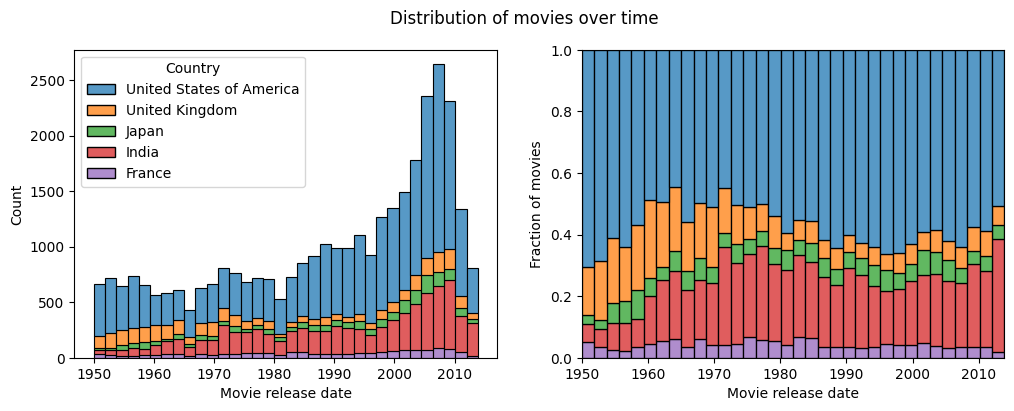

In [68]:
movies = clean.keep_dates(movies_parsed, 1950, 2013)
characters = clean.keep_dates(characters_parsed, 1950, 2013)
plot.movie_distribution_over_time(movies)

This leaves us with 40% of the original movies and 55% of the original characters.

In [69]:
ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
ncharacters = aggregate.ncharacters(characters)
nactors = aggregate.nactors(characters)
print('Finished filtering countries of interest:')
print(f'- Number of countries:  {ncountries} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of characters: {ncharacters} ({ncharacters / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors} ({nactors / nactors_raw:.1%})')

Finished filtering countries of interest:
- Number of countries:  5 (3.4%)
- Number of movies:     34008 (41.6%)
- Number of characters: 245207 (54.4%)
- Number of actors:     74133 (54.6%)


Add year and decade columns for convenient grouping.

In [70]:
clean.add_year_and_decade(movies)
clean.add_year_and_decade(characters)
movies.head(5)

,index,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_Name,Movie_Release_Date,Revenue,Movie_Runtime,Movie_Languages,Movie_Countries,Movie_Genres,year,decade
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,Thriller,2001,2000
1,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,Science Fiction,2001,2000
2,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,Horror,2001,2000
3,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,Adventure,2001,2000
4,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,Supernatural,2001,2000


## (@Everyone before starting analysis)

Note that there can be multiple movie rows for the same movie ID, e.g. when there are multiple genres, so you have to filter!

In [71]:
# All the same movie
movies[['Wikipedia_Movie_ID', 'Movie_Name', 'Revenue', 'Movie_Countries', 'Movie_Genres']].head(5)

,Wikipedia_Movie_ID,Movie_Name,Revenue,Movie_Countries,Movie_Genres
0,975900,Ghosts of Mars,14010832.0,United States of America,Thriller
1,975900,Ghosts of Mars,14010832.0,United States of America,Science Fiction
2,975900,Ghosts of Mars,14010832.0,United States of America,Horror
3,975900,Ghosts of Mars,14010832.0,United States of America,Adventure
4,975900,Ghosts of Mars,14010832.0,United States of America,Supernatural


Example of filtering on your variable of interest (here movie revenue): 

In [72]:
revenues = movies[['Wikipedia_Movie_ID', 'Revenue', 'Movie_Countries']].drop_duplicates()
revenues.head(5)

,Wikipedia_Movie_ID,Revenue,Movie_Countries
0,975900,14010832.0,United States of America
7,3196793,NaN,United States of America
11,9363483,NaN,United Kingdom
27,2345652,NaN,United Kingdom
31,24229100,NaN,Japan


## 3. Analysis of different movie industries

General note: I think one thing we have to be careful of is that results will vary over time (as movie industries have changed over time).
Therefore, it might be smart to split movies into periods and compare the evolution for each country.
Did the movie industries diverge or converge?

### 3.1 Trends in movie industries

#### 3.1.1 Movie durations

Some cleaning to do, there are movies with durations of 1 minute and 1000000 minutes, have to check whether these make sense or are errors and filter them out:

In [73]:
runtimes = movies[['Wikipedia_Movie_ID', 'Movie_Runtime', 'Movie_Countries', 'decade']].drop_duplicates()
runtimes.Movie_Runtime.describe()

count    2.796500e+04
mean     1.380803e+02
std      6.453918e+03
min      1.000000e+00
25%      8.600000e+01
50%      9.500000e+01
75%      1.100000e+02
max      1.079281e+06
Name: Movie_Runtime, dtype: float64

Aside from the outliers, it seems that movies from all countries are relativaly the same length, except for indian movies who appear twice as long!
Over time duration from other countries seems to slightly increase while indian movies seem to decrease.

<AxesSubplot: xlabel='decade', ylabel='Movie_Runtime'>

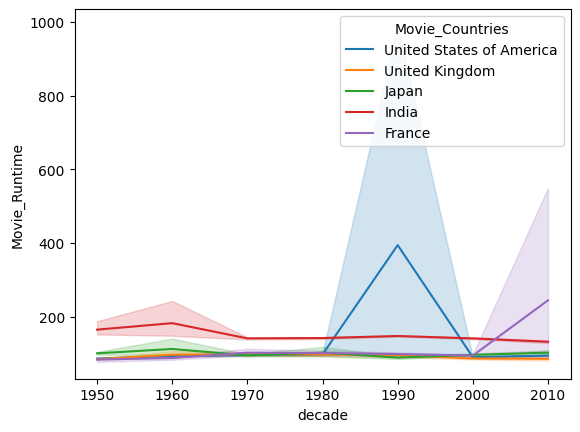

In [74]:
sns.lineplot(data=runtimes, x='decade', y='Movie_Runtime', hue='Movie_Countries')

#### 3.1.2 Movie revenue

Lots of movies with missing revenue.
We therefore need to find a reliable source to obtain these missing revenue and pull them in for better analysis.
Since we're doing this analysis over time, it would be interesting to adjust these revenue over inflation, for which we also need a reliable data source. (also have to decide whether we're taking global inflation rate or inflation rate per country)

In [75]:
missing_revenues = aggregate.nmovies(movies[movies.Revenue.isna()])
print(f"We have {missing_revenues/nmovies:.1%} movies with missing revenue")

We have 83.8% movies with missing revenue


Because of the missing revenue (especially for Indian and Japanese movies) the values are a little all over the place.

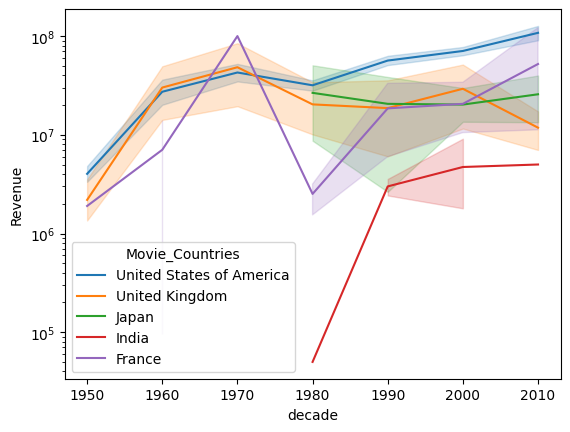

In [76]:
revenues = movies[['Wikipedia_Movie_ID', 'Revenue', 'Movie_Countries', 'decade']].drop_duplicates()
g = sns.lineplot(data=revenues, x='decade', y='Revenue', hue='Movie_Countries')
g.set_yscale('log')
plt.show()

#### 3.1.3 Budget

This should be the same analysis as revenue, but now for budget, a category that is completely missing from the original data.
We therefore need a reliable data source, adjust it for inflation, and then perform the analysis.

#### 3.1.4 Movie genres

This will need some creativity as I'm not sure if the below visualization is the best.
Perhaps comparing the fraction of a genre relative to other genres within a country (within each period) would be more appropriate.
More experimenting is needed here!

<AxesSubplot: xlabel='Count', ylabel='Movie_Genres'>

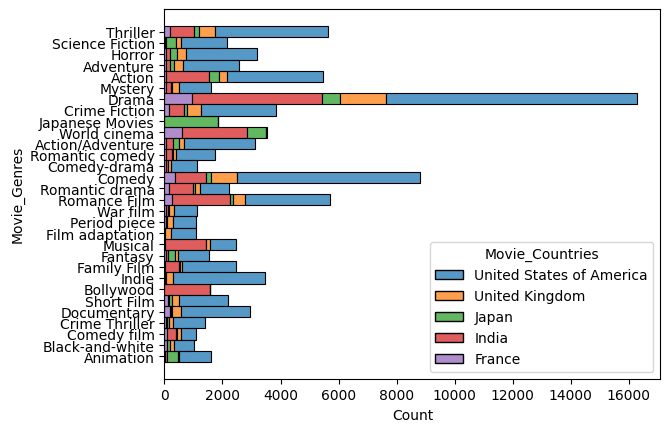

In [77]:
genres = movies[['Movie_Countries', 'Movie_Genres', 'decade']]
genres = genres.groupby(['Movie_Genres']).filter(lambda x: len(x) >= 1000)
sns.histplot(genres, y='Movie_Genres', hue='Movie_Countries', multiple='stack')

In [121]:
# get top 10 genres for each country
top_genres = movies[['Movie_Countries', 'Movie_Genres', 'decade']]
top_genres = top_genres.groupby(['Movie_Countries', 'Movie_Genres']).size().reset_index(name='counts')
top_genres = top_genres.sort_values(['Movie_Countries', 'counts'], ascending=[True, False])


In [122]:
top_genres.groupby('Movie_Countries').head(10)

,Movie_Countries,Movie_Genres,counts
59,France,Drama,953
172,France,World cinema,597
33,France,Comedy,378
137,France,Romance Film,272
164,France,Thriller,199
56,France,Documentary,181
48,France,Crime Fiction,172
139,France,Romantic drama,165
146,France,Short Film,121
35,France,Comedy film,79


Top 10 genres of each country

<AxesSubplot: xlabel='Count', ylabel='Movie_Genres'>

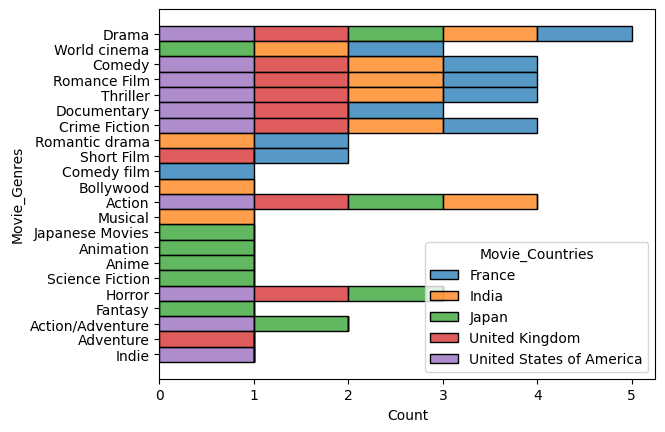

In [124]:
# plot top 10 genres for each country
top_genres = top_genres.groupby('Movie_Countries').head(10)
sns.histplot(top_genres, y='Movie_Genres', hue='Movie_Countries', multiple='stack')



#### 3.1.5 NLP insights


In [221]:
# read plot summaries
summaries_df = pd.read_csv('../data/MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['Wikipedia_Movie_ID', 'Plot_Summary'])

In [222]:
summaries_df.head(5)

,Wikipedia_Movie_ID,Plot_Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [223]:
# match wikipedia movie ids 
movies_sum = movies.merge(summaries_df, on='Wikipedia_Movie_ID', how='left')

In [227]:
movies_sum = movies_sum[["Movie_Name", "Movie_Countries", "Movie_Genres", "Movie_Runtime", "Revenue", "Plot_Summary"]].drop_duplicates()

In [247]:
movies_sum.dropna(subset=['Plot_Summary'], inplace=True)

In [248]:
len(movies_sum)

81171

In [249]:
# group summaries by genre and minmum number of char
summaries_gp = movies_sum.groupby(['Movie_Genres'])


In [250]:
summaries_gp.describe()

Movie_Runtime                                                \
                         count        mean           std   min    25%    50%   
Movie_Genres                                                                   
Absurdism                 59.0   94.067797     21.757174  30.0   86.0   91.0   
Acid western               4.0   90.750000      0.957427  90.0   90.0   90.5   
Action                  2954.0  473.248043  19855.815835   1.5   90.0  100.0   
Action Comedy             71.0   98.422535     18.761406   8.0   91.0   99.0   
Action Thrillers         249.0  104.220884     19.787057  57.0   91.0   99.0   
...                        ...         ...           ...   ...    ...    ...   
Workplace Comedy          61.0  100.196721     14.281479  77.0   89.0   98.0   
World History              4.0  176.000000    245.514426  40.0   55.0   60.0   
World cinema            2147.0  131.103891     49.699273  23.0  105.0  134.0   
Z movie                    2.0  100.000000     35.355339  75.0   87.5  100.0   
Zombie Film              137.0   87.116788     13.482050  17.0   84.0   89.0   

                                    Revenue                              \
                     75%        max   count          mean           std   
Movie_Genres                                                              
Absurdism          96.50      224.0    37.0  7.522848e+07  1.106102e+08   
Acid western       91.25       92.0     0.0           NaN           NaN   
Action            117.00  1079281.0  1087.0  8.928732e+07  1.629585e+08   
Action Comedy     105.00      146.0    52.0  8.209634e+07  1.145668e+08   
Action Thrillers  114.00      204.0   106.0  1.034876e+08  1.431546e+08   
...                  ...        ...     ...           ...           ...   
Workplace Comedy  107.00      144.0    33.0  6.846822e+07  9.527865e+07   
World History     181.00      544.0     0.0           NaN           NaN   
World cinema      151.00     1966.0    95.0  1.796960e+07  2.783484e+07   
Z movie           112.50      125.0     0.0           NaN           NaN   
Zombie Film        93.00      115.0    25.0  4.226876e+07  1.154155e+08   

                                                                    \
                        min          25%         50%           75%   
Movie_Genres                                                         
Absurdism          118192.0   7027290.00  36145695.0  9.925546e+07   
Acid western            NaN          NaN         NaN           NaN   
Action              13276.0   6008754.50  25819961.0  9.320364e+07   
Action Comedy     2500000.0  13447683.25  34597148.5  8.609358e+07   
Action Thrillers   199436.0  12609880.00  42307113.5  1.606968e+08   
...                     ...          ...         ...           ...   
Workplace Comedy   139084.0   7138523.00  26983776.0  9.057419e+07   
World History           NaN          NaN         NaN           NaN   
World cinema        24625.0   2376301.00   6548779.0  2.697482e+07   
Z movie                 NaN          NaN         NaN           NaN   
Zombie Film         54207.0   5364858.00  14182492.0  3.003939e+07   

                                
                           max  
Movie_Genres                    
Absurdism         5.814643e+08  
Acid western               NaN  
Action            1.511758e+09  
Action Comedy     6.243867e+08  
Action Thrillers  8.908716e+08  
...                        ...  
Workplace Comedy  3.741117e+08  
World History              NaN  
World cinema      2.026143e+08  
Z movie                    NaN  
Zombie Film       5.853490e+08  

[330 rows x 16 columns]

The all-MiniLM-L6 https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2] is a light model good to detect semantics

In [251]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [252]:
# print genres
for genre in summaries_gp.groups.keys():
    print(genre)

Absurdism
Acid western
Action
Action Comedy
Action Thrillers
Action/Adventure
Addiction Drama
Adult
Adventure
Adventure Comedy
Airplanes and airports
Albino bias
Alien Film
Alien invasion
Americana
Animal Picture
Animals
Animated Musical
Animated cartoon
Animation
Anime
Anthology
Anti-war
Anti-war film
Apocalyptic and post-apocalyptic fiction
Archaeology
Archives and records
Art film
Auto racing
Avant-garde
B-Western
B-movie
Backstage Musical
Baseball
Beach Film
Beach Party film
Bengali Cinema
Biker Film
Biographical film
Biography
Biopic [feature]
Black comedy
Black-and-white
Blaxploitation
Bloopers & Candid Camera
Bollywood
Boxing
Breakdance
British Empire Film
British New Wave
Buddy cop
Buddy film
Business
C-Movie
Camp
Caper story
Cavalry Film
Chase Movie
Chick flick
Childhood Drama
Children's
Children's Entertainment
Children's Fantasy
Children's Issues
Children's/Family
Christian film
Christmas movie
Cold War
Combat Films
Comedy
Comedy Thriller
Comedy Western
Comedy film
Comedy ho

In [254]:
%%time  
# encode action movies and romance movies
# perform the embedding only for one genre
action_embeddings = model.encode(summaries_gp.get_group('Action').Plot_Summary.tolist())
romance_embeddings = model.encode(summaries_gp.get_group('Romance Film').Plot_Summary.tolist())

CPU times: total: 32.6 s
Wall time: 15.2 s


In [255]:
# ploting tsne for action and romance movies
from sklearn.manifold import TSNE
random_state = 42
model_tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=random_state)

In [256]:
action_tsne = model_tsne.fit_transform(action_embeddings)
romance_tsne = model_tsne.fit_transform(romance_embeddings)

c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


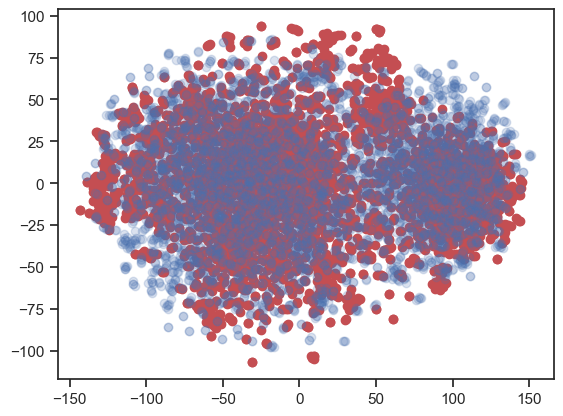

In [259]:
plt.scatter(action_tsne[:, 0], action_tsne[:, 1], c='r', label='Action')
plt.scatter(romance_tsne[:, 0], romance_tsne[:, 1], c='b', label='Romance', alpha=0.2)

We see an overlap between 2 genres plots on a symmantic level with some differences. A throughout analysis will be presented by P3 

We would like as well to determine the most significant x events. this is done by analyzing and studying the similarity between an event in a plot (sentence) and all the other remaing events happening.

In [265]:
movie_samples = movies_sum.sample(3, random_state=3)

In [266]:
movie_samples.head(3)

,Movie_Name,Movie_Countries,Movie_Genres,Movie_Runtime,Revenue,Plot_Summary
31096,Unbreakable,United States of America,Supernatural,107.0,248118121.0,Elijah Price is born with Type I osteogenesis...
19663,Pale Cocoon,Japan,Short Film,23.0,NaN,It has been many years since a group of humans...
63940,Talkin' Dirty After Dark,United States of America,Comedy,89.0,NaN,Stand up comedian Terry is a local funny man ...


In [270]:
# tokinize the plot summaries as sentences # a standard split would have been sufficient for these samples
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
movie_samples['Plot_Summary_sent'] = movie_samples['Plot_Summary'].apply(lambda x: sent_tokenize(x))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rayendhahri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [271]:
movie_samples.head(3)

,Movie_Name,Movie_Countries,Movie_Genres,Movie_Runtime,Revenue,Plot_Summary,Plot_Summary_sent
31096,Unbreakable,United States of America,Supernatural,107.0,248118121.0,Elijah Price is born with Type I osteogenesis...,[Elijah Price is born with Type I osteogenesi...
19663,Pale Cocoon,Japan,Short Film,23.0,NaN,It has been many years since a group of humans...,[It has been many years since a group of human...
63940,Talkin' Dirty After Dark,United States of America,Comedy,89.0,NaN,Stand up comedian Terry is a local funny man ...,[Stand up comedian Terry is a local funny man...


In [272]:
model_kps = SentenceTransformer("nlpaueb/bert-base-uncased-echr") # The warning is expected

No sentence-transformers model found with name C:\Users\rayendhahri/.cache\torch\sentence_transformers\nlpaueb_bert-base-uncased-echr. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\rayendhahri/.cache\torch\sentence_transformers\nlpaueb_bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to

In [280]:
def gen_match_matrix(model, sents, min_match_score=0):
    """Generate a matrix of sentence matches for a list of sentences"""
    sents1 = [x for x in sents]
    sents1_embeddings = model.encode(sents1)
    sim_matrix = cosine_similarity(sents1_embeddings, sents1_embeddings)
    super_threshold_indices = sim_matrix < min_match_score
    sim_matrix[super_threshold_indices] = 0
    #print(sim_matrix)
    return sim_matrix

In [281]:
def filter_ranked_list(ranked_sents, model, min_match=0.8, N=3):
    """a ranked list of sentences is filtered by removing sentences that are too similar to other sentences in the list
    N is the number of sentences to return"""
    ranked_sents = [x[0] for x in ranked_sents]
    filtered_sents = []
    for i, s in enumerate(ranked_sents):
        if len(filtered_sents) >= N or len(filtered_sents) >= len(ranked_sents):
            break
        if len(filtered_sents) == 0:
            filtered_sents.append(s)
        else:
            matching_scores = gen_match_matrix(model, [s] + filtered_sents)
            max_sim = np.max(matching_scores[0][1:])
            # print(matching_scores)
            if max_sim < min_match:
                filtered_sents.append(s)
        
        # print(min_match)
    
    return filtered_sents

In [282]:
def apply_page_rank(sentences, p=0.85, min_match_score=0.5, min_len=5, max_len=35):
    """Apply page rank to a list of sentences
    min_match_score: minimum similarity score for two sentences to be considered similar
    min_len: minimum length of a sentence
    max_len: maximum length of a sentence
    returns a ranked list of sentences
    """
    cand_sents = [x for x in sentences if len(x.split()) < max_len and len(x.split()) > min_len]
    if len(cand_sents) == 0:
        #print('empty')
        return []
    # print(cands)
    # print(cands_qualities)
    cands_matching_mat = gen_match_matrix(model, cand_sents, min_match_score=min_match_score)
    pr = pagerank(cands_matching_mat, p=p)  # it looks like modifying the initial probability doesn't help
    # pr=pagerank(cands_matching_mat, p=p)
    ranked_candidates = list(zip(cand_sents, pr))
    return sorted(ranked_candidates, key=lambda x: -x[1])

In [291]:
# lets get 3 most influencial sentences for each movie
movie_samples["summary_kps"] = movie_samples["Plot_Summary_sent"].apply(lambda x: apply_page_rank(x, p=0.85, min_match_score=0.5, min_len=5, max_len=35))
movie_samples["summary_kps"] = movie_samples["summary_kps"].apply(lambda x: filter_ranked_list(x, model_kps, min_match=0.8, N=3))

c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [293]:
# display the results full sentences
movie_samples[["Movie_Name", "summary_kps"]]


,Movie_Name,summary_kps
31096,Unbreakable,[David tries to console his son by saying that...
19663,Pale Cocoon,[It has been many years since a group of human...
63940,Talkin' Dirty After Dark,[He is struggling trying to make it at a local...


### 3.2 Diversity across industries

Possible metrics between countries:
- Age
- Gender ratio
- Ethnicity (although not much data, not sure if we can complete w/ other datasources)
- Actor height compared to national averages

This task should be similar to H1, just comparing populations using the appropriate statistic metrics.

Initial needed data wrangling:
- Age should be in the right range
- Gender ratio in an appropriate format for comparing
- Check if there is enough ethnicity data and if not try to obtain them from outside data source
- Obtain national heigh averages and compare them with appropriate methods

#### 3.2.1 Age

In [22]:
# assign to new variable
char_age = characters
characters.head()

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000


In [23]:
char_age.describe()

,index,Wikipedia_Movie_ID,Actor_Height,Actor_Age_at_Movie_Release,year,decade
count,245207.000000,2.452070e+05,100825.000000,179121.000000,245207.000000,245207.000000
mean,148160.420233,1.266403e+07,1.769042,38.487319,1990.985453,1986.427427
std,85657.513265,1.056733e+07,2.885711,23.652003,17.483030,17.519729
min,0.000000,3.217000e+03,0.813000,-7896.000000,1950.000000,1950.000000
25%,73958.500000,3.077087e+06,1.680000,28.000000,1979.000000,1970.000000
50%,148033.000000,9.653698e+06,1.750000,37.000000,1996.000000,1990.000000
75%,222651.500000,2.170312e+07,1.830000,48.000000,2006.000000,2000.000000
max,296570.000000,3.750192e+07,510.000000,103.000000,2013.000000,2010.000000


There are still some inconsistencies in age which have to be filtered out. Data with negative age and NaN value will be removed.

In [24]:
# data with errors
char_age[char_age.Actor_Age_at_Movie_Release < 0].head()

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
6948,6948,31163724,United States of America,/m/0gdk5td,1956-01-01,NaN,1973,M,NaN,NaN,Eric Chase Anderson,-17.0,/m/0gdljss,NaN,/m/026xg0t,1956,1950
8933,8933,21242801,United States of America,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0,1955,1950
13184,13184,20019382,United States of America,/m/04y9xhm,1977-09-28,El Raheem,2004-01-13,M,NaN,NaN,Don Blakely,-26.0,/m/0cgrzfq,/m/0cgrzft,/m/0bhh1hn,1977,1970
21795,21795,5261848,United States of America,/m/0dbfw4,1988-01-24,NaN,1992-10-19,NaN,NaN,NaN,Perry Allen,-4.0,/m/06mg50n,NaN,/m/06mg50r,1988,1980
23194,23194,11143228,India,/m/02r1gz2,1976-01-01,NaN,1982,F,NaN,NaN,Vijayalakshmi Agathiyan,-6.0,/m/0kn359c,NaN,/m/04gltqm,1976,1970


This is the data without missing/wrong data about the actor's age:

In [25]:
# clean dataframe
char_age[char_age.Actor_Age_at_Movie_Release > 0].dropna(subset='Actor_Age_at_Movie_Release')

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296563,296563,913762,Japan,/m/03pcrp,1992-05-21,Lord Feff,1960-04-28,M,NaN,NaN,Steven Blum,32.0,/m/0kr408g,/m/0kr408l,/m/044_7j,1992,1990
296565,296565,913762,Japan,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz,1992,1990
296566,296566,913762,Japan,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992,1990
296567,296567,913762,Japan,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992,1990


For some characters age is missing but can be calculated with DOB and Release Date of the movie. Even in the Actor_DOB column exist inconsistencies, as the supposed actor was born in 1498 and took part in a movie almost 300 years later:

In [26]:
# characters with dob (date of birth) and mrd (movie release date) but not age at movie release
dob_mrd_char = char_age[char_age.Actor_Age_at_Movie_Release.isnull()].dropna(subset=['Actor_DOB', 'Movie_Release_Date'])
dob_mrd_char[pd.to_datetime(dob_mrd_char.Actor_DOB, format='%Y/%m/%d', errors='coerce').isnull()]

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
2464,2464,21038272,India,/m/05b268g,1979-01-01,NaN,1498,F,NaN,NaN,Mirabai,NaN,/m/05cnn3x,NaN,/m/03h165,1979,1970
121161,121161,20072112,United States of America,/m/04n46f5,2008-01-01,NaN,1075-08-19,F,NaN,NaN,Holly Eglington,NaN,/m/0gc7_rh,NaN,/m/0gc64t0,2008,2000


In [27]:
# drop these rows
remove_idx = dob_mrd_char[pd.to_datetime(dob_mrd_char.Actor_DOB, format='%Y/%m/%d', errors='coerce').isnull()].index
char_age = char_age.drop(labels=remove_idx, axis=0)
char_age

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296566,296566,913762,Japan,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992,1990
296567,296567,913762,Japan,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992,1990
296568,296568,913762,Japan,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h,1992,1990
296569,296569,913762,Japan,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992,1990


In [28]:
# convert into date format to extract year
dob_mrd_char.Actor_DOB = pd.to_datetime(dob_mrd_char.Actor_DOB, format='%Y/%m/%d', errors='coerce')
dob_mrd_char.Movie_Release_Date = pd.to_datetime(dob_mrd_char.Movie_Release_Date, format='%Y/%m/%d', errors='coerce')
dob_mrd_char

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
85,85,77856,United States of America,/m/0kcn7,1964-08-27,The Constable,1894-07-23 00:00:00,M,NaN,NaN,Arthur Treacher,NaN,/m/0cg2t2_,/m/0h5njw9,/m/020csj,1964,1960
87,87,77856,United States of America,/m/0kcn7,1964-08-27,Uncle Albert,1886-11-09 00:00:00,M,1.8200,NaN,Ed Wynn,NaN,/m/05nn480,/m/05ysxy5,/m/01k67w,1964,1960
91,91,77856,United States of America,/m/0kcn7,1964-08-27,Admiral Boom,1887-08-05 00:00:00,M,NaN,NaN,Reginald Owen,NaN,/m/0csl6kq,/m/0h5njw2,/m/0b47ns,1964,1960
280,280,5915856,India,/m/0fdc85,2003-10-01,NaN,1970-09-09 00:00:00,M,NaN,NaN,Biju Menon,NaN,/m/0j_1kz,NaN,/m/0g9d5d,2003,2000
281,281,5915856,India,/m/0fdc85,2003-10-01,NaN,1965-12-10 00:00:00,M,NaN,NaN,Jayaram,NaN,/m/0j_1kn,NaN,/m/075p0r,2003,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296120,296120,25431214,India,/m/09k5h57,2009-12-01,Mathews,1960-05-21 00:00:00,M,1.7200,/m/0dryh9k,Mohanlal,NaN,/m/0gvzwgy,/m/0h1j8l9,/m/02fbpz,2009,2000
296121,296121,25431214,India,/m/09k5h57,2009-12-01,Adv. Sunitha,1989-05-05 00:00:00,F,1.7018,/m/074w_m,Lakshmi Rai,NaN,/m/0gvz_3b,/m/0h34ydz,/m/02pnknk,2009,2000
296122,296122,25431214,India,/m/09k5h57,2009-12-01,Adv. Prabalan,1956-04-06 00:00:00,M,NaN,/m/046cwm,Sreenivasan,NaN,/m/0hh977l,/m/0hh977p,/m/05gc0h,2009,2000
296123,296123,25431214,India,/m/09k5h57,2009-12-01,NaN,1985-06-30 00:00:00,F,NaN,NaN,Priyanka Nair,NaN,/m/0n9_2kr,NaN,/m/0czbskd,2009,2000


The age of the actors are based on the year of birth and year of movie release as the data does not provide a consistent format including day and month dates for all subjects.

In [29]:
def calc_age(df1, df2):
    """
    Calculates the age of the actor
    """
    return df1.year - df2.year

In [30]:
# replace the actors' calculated ages and remove the wrong data
dob_mrd_char.Actor_Age_at_Movie_Release = dob_mrd_char.apply(lambda x: calc_age(x.Movie_Release_Date, x.Actor_DOB), axis=1)
dob_mrd_char = dob_mrd_char.drop(labels=remove_idx, axis=0)

In [31]:
# replace NaN with calculated age in original dataframe
char_age.Actor_Age_at_Movie_Release.loc[dob_mrd_char.index] = dob_mrd_char.Actor_Age_at_Movie_Release

C:\Users\Tim\AppData\Local\Temp\ipykernel_13784\1898141241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_age.Actor_Age_at_Movie_Release.loc[dob_mrd_char.index] = dob_mrd_char.Actor_Age_at_Movie_Release


In [32]:
# cleansed data
char_age = char_age[char_age.Actor_Age_at_Movie_Release > 0].dropna(subset='Actor_Age_at_Movie_Release')
char_age

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296565,296565,913762,Japan,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz,1992,1990
296566,296566,913762,Japan,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992,1990
296567,296567,913762,Japan,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992,1990
296569,296569,913762,Japan,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,22.0,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992,1990


There are still some outliers as some movies include retrospectives on older movies with the same character (especially animation movies). This data is not representative for our analysis and will be filtered out as well. According to Roser et al. the life expectancy in the chosen countries was around 80 years in 2005. We will therefore set a threshold at 90 years to account for the increase in life expectancy with improved healthcare and some possible outliers.

Source: https://ourworldindata.org/life-expectancy

<AxesSubplot: title={'center': 'Actor_Age_at_Movie_Release'}, xlabel='Movie_Countries'>

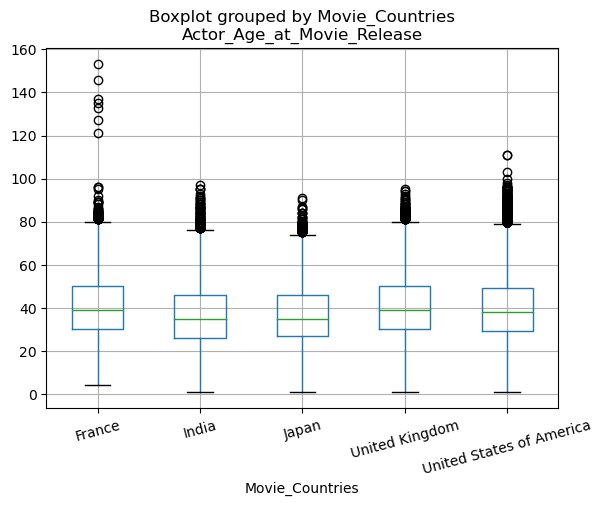

In [33]:
# plot data to check for further inconsistencies
char_age.boxplot(by='Movie_Countries', column='Actor_Age_at_Movie_Release', rot=15)

In [34]:
# filter out errors
char_age = char_age[char_age.Actor_Age_at_Movie_Release < 90]

For 25.7 % of the given actors we can analyze the age distribution:

In [35]:
ncharacters_age = aggregate.ncharacters(char_age)
nactors_age = aggregate.nactors(char_age)
print(f'- Number of characters: {ncharacters_age} ({ncharacters_age / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors_age} ({nactors_age / nactors_raw:.1%})')

- Number of characters: 87807 (47.9%)
- Number of actors:     34892 (25.7%)


In average over all the years from 1950 to 2013 the statistics in the Big 5 countries is very similar. Most of the actors were between 26 and 50 years old.

In [36]:
# compare countries' statistic
char_age.groupby('Movie_Countries').Actor_Age_at_Movie_Release.describe()

,count,mean,std,min,25%,50%,75%,max
Movie_Countries,,,,,,,,
France,4864.0,40.847656,14.795182,4.0,30.0,39.0,50.0,89.0
India,31522.0,36.720989,13.295800,1.0,26.0,35.0,46.0,89.0
Japan,7961.0,37.127371,13.671876,1.0,27.0,35.0,46.0,87.0
United Kingdom,17675.0,40.377595,13.910450,1.0,30.0,39.0,50.0,89.0
United States of America,127262.0,39.379178,14.686246,1.0,29.0,38.0,49.0,89.0


<AxesSubplot: title={'center': 'Actor_Age_at_Movie_Release'}, xlabel='Movie_Countries'>

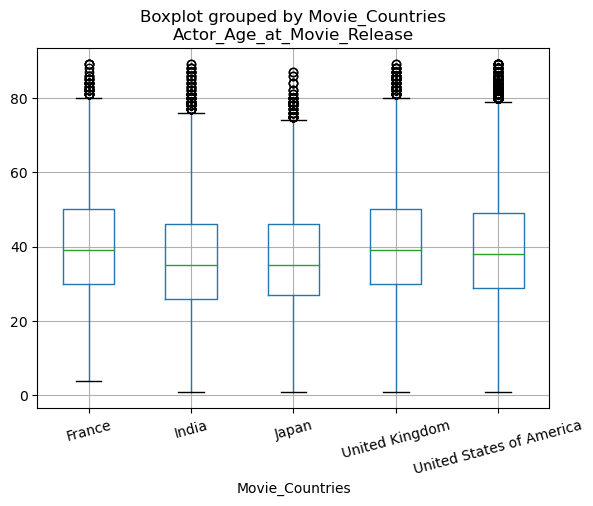

In [37]:
# plot new dataframe
char_age.boxplot(by='Movie_Countries', column='Actor_Age_at_Movie_Release', rot=15)

Whereas in the 50's the USA, UK and France had a similar age of movie actors (~ 39 years), Japan and India had younger actors. With a rather strong decline in the 60's in France, France and Japan show a trend towards older actors in movies. In general the range of actors' ages is low in the USA and UK compared to the other three countries.

C:\Users\Tim\AppData\Local\Temp\ipykernel_13784\1556813850.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=char_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)


<AxesSubplot: xlabel='decade', ylabel='Actor_Age_at_Movie_Release'>

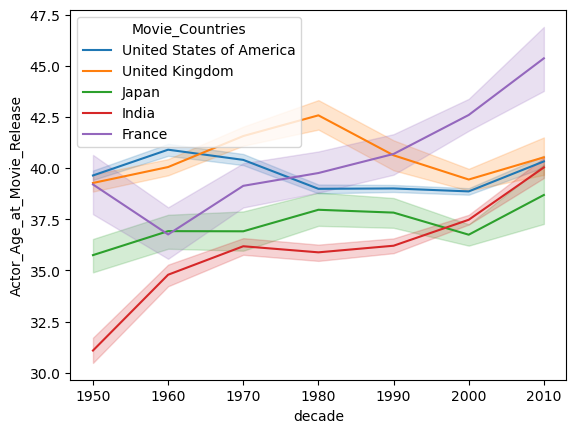

In [38]:
# compare over decades
# CI of 95 % was added
sns.lineplot(data=char_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)

#### 3.2.2 Gender

In [39]:
# assign to new variable
char_gender = characters

In [40]:
no_nan_gender = len(char_gender[char_gender.Actor_Gender.isna()])
print(f"There are {no_nan_gender} NaN values for the gender of actors.")

There are 21395 NaN values for the gender of actors.


In [41]:
# drop missing data
char_gender = char_gender.dropna(subset='Actor_Gender')

For 41.1 % of the given actors we can analyze the gender ratio:

In [42]:
ncharacters_gender = aggregate.ncharacters(char_gender)
nactors_gender = aggregate.nactors(char_gender)
print(f'- Number of characters: {ncharacters_gender} ({ncharacters_gender / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors_gender} ({nactors_gender / nactors_raw:.1%})')

- Number of characters: 107876 (58.8%)
- Number of actors:     55770 (41.1%)


In general the number of female actors in movies was much less than the number of male actors. Is the movie industry really male dominated or did it change over time?

In [43]:
# compare male and female in different countries
char_gender.groupby(['Actor_Gender', 'Movie_Countries'])['Actor_Gender'].count()

Actor_Gender  Movie_Countries         
F             France                       2391
              India                       14411
              Japan                        3385
              United Kingdom               6254
              United States of America    48165
M             France                       3746
              India                       27816
              Japan                        5514
              United Kingdom              13469
              United States of America    98661
Name: Actor_Gender, dtype: int64

[Text(0, 0, 'United States of America'),
 Text(1, 0, 'United Kingdom'),
 Text(2, 0, 'Japan'),
 Text(3, 0, 'India'),
 Text(4, 0, 'France')]

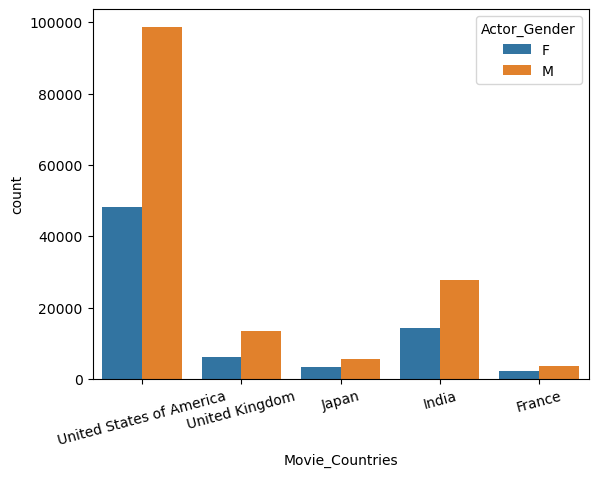

In [44]:
# plot data
gender_plot = sns.countplot(data=char_gender, x='Movie_Countries', hue='Actor_Gender')
gender_plot.set_xticklabels(gender_plot.get_xticklabels(), rotation=15)

In [45]:
# split the data into two columns and creating indicator variables for Male and Female
char_gender = pd.get_dummies(char_gender, columns=['Actor_Gender'])
char_gender.head()

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade,Actor_Gender_F,Actor_Gender_M
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000,1,0
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000,1,0
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000,0,1
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000,0,1
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000,1,0


In [46]:
# calculate male/female ratio for decades
grouped_gender = char_gender.groupby(['decade', 'Movie_Countries'])
gender_ratio = grouped_gender['Actor_Gender_F']\
    .sum().div(grouped_gender['Actor_Gender_M'].sum())

In [47]:
# create new dataframe
df_gender_ratio = pd.DataFrame(gender_ratio, columns=['Ratio F/M'])

Except for India there is a trend towards more actresses in movies. Only India shows a trend towards more male actors. However, India had the highest ratio in the 50's. In none of the countries were as many male as female actors in 2013.

<AxesSubplot: xlabel='decade', ylabel='Ratio F/M'>

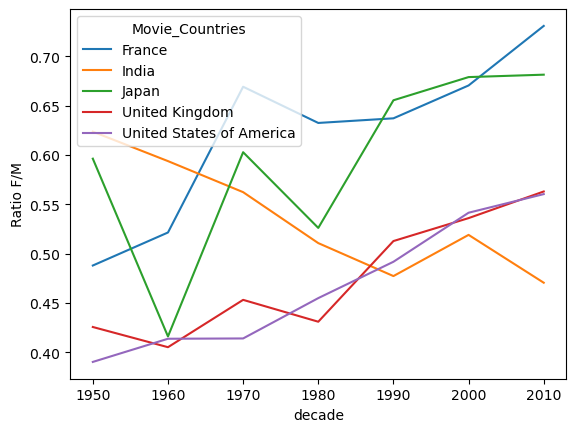

In [48]:
# plot new dataframe
sns.lineplot(data=df_gender_ratio, x='decade', y='Ratio F/M', hue='Movie_Countries')

We will now compare the age between male and female actors in the different countries.
In average female actors are much younger (33.82 +/- 13.9) than male actors (41.55 +/- 13.94).

In [49]:
# use gender as additional information
age_gender = pd.get_dummies(char_age, columns=['Actor_Gender'])

In [50]:
# assign data to male/female
female_age = age_gender[age_gender.Actor_Gender_F == 1]
male_age = age_gender[age_gender.Actor_Gender_M == 1]

In [51]:
female_age.Actor_Age_at_Movie_Release.describe()

count    62511.000000
mean        33.823807
std         13.901891
min          1.000000
25%         24.000000
50%         31.000000
75%         41.000000
max         89.000000
Name: Actor_Age_at_Movie_Release, dtype: float64

In [52]:
male_age.Actor_Age_at_Movie_Release.describe()

count    125823.000000
mean         41.546490
std          13.937652
min           1.000000
25%          31.000000
50%          40.000000
75%          51.000000
max          89.000000
Name: Actor_Age_at_Movie_Release, dtype: float64

France has in average the oldest actresses whereas India has the youngest. The male actors are in every country around the same age.

In [53]:
female_age.groupby('Movie_Countries')['Actor_Age_at_Movie_Release'].describe()

,count,mean,std,min,25%,50%,75%,max
Movie_Countries,,,,,,,,
France,1890.0,36.614815,14.913436,5.0,26.0,33.0,44.0,89.0
India,11184.0,28.854793,11.361938,1.0,22.0,26.0,33.0,89.0
Japan,2969.0,31.818121,12.759857,1.0,23.0,29.0,38.0,86.0
United Kingdom,5440.0,35.981066,14.458219,2.0,25.0,32.0,44.0,89.0
United States of America,41028.0,34.908867,14.155075,1.0,25.0,32.0,42.0,89.0


In [54]:
male_age.groupby('Movie_Countries')['Actor_Age_at_Movie_Release'].describe()

,count,mean,std,min,25%,50%,75%,max
Movie_Countries,,,,,,,,
France,2937.0,43.556691,14.037038,4.0,33.0,42.0,53.0,89.0
India,20291.0,41.051550,12.254879,1.0,32.0,40.0,49.0,89.0
Japan,4916.0,40.414565,13.168855,3.0,31.0,39.0,49.0,87.0
United Kingdom,12141.0,42.328391,13.169950,1.0,33.0,41.0,51.0,89.0
United States of America,85538.0,41.548949,14.436784,1.0,31.0,40.0,51.0,89.0


C:\Users\Tim\AppData\Local\Temp\ipykernel_13784\7704309.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=female_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)


<AxesSubplot: xlabel='decade', ylabel='Actor_Age_at_Movie_Release'>

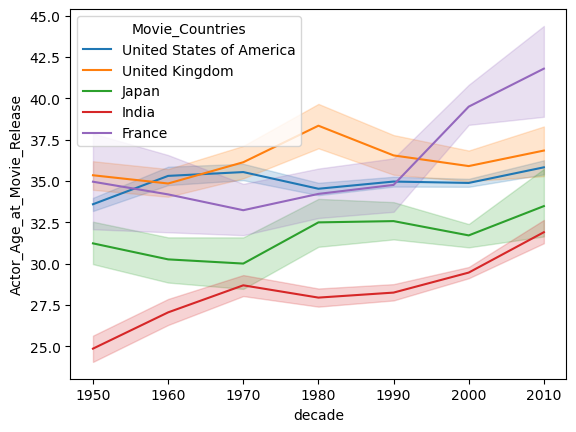

In [55]:
# Age of women in movie industry in different countries
# CI of 95 % was added
sns.lineplot(data=female_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)

C:\Users\Tim\AppData\Local\Temp\ipykernel_13784\855587707.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=male_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)


<AxesSubplot: xlabel='decade', ylabel='Actor_Age_at_Movie_Release'>

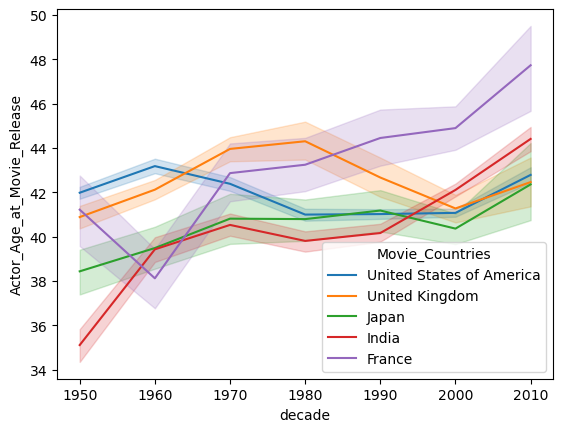

In [56]:
# Age of men in movie industry in different countries
# CI of 95 % was added
sns.lineplot(data=male_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)

#### 3.2.3 Ethnicity

In [57]:
# assign new variable
char_ethnicity = characters

In [58]:
no_nan_ethnicity = len(char_ethnicity[char_ethnicity.Actor_Ethnicity.isna()])
print(f"There are {no_nan_ethnicity} NaN values for the ethnicity of actors.")

There are 173766 NaN values for the ethnicity of actors.


In [59]:
# drop rows with missing values
char_ethnicity = char_ethnicity.dropna(subset='Actor_Ethnicity')

For 5 % of the given actors we can analyze the ethnicity:

In [60]:
ncharacters_ethn = aggregate.ncharacters(char_ethnicity)
nactors_ethn = aggregate.nactors(char_ethnicity)
print(f'- Number of characters: {ncharacters_ethn} ({ncharacters_ethn / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors_ethn} ({nactors_ethn / nactors_raw:.1%})')

- Number of characters: 42943 (23.4%)
- Number of actors:     6777 (5.0%)


Since there are so many different ethnicities but not much data about actors' ehtnicities, we try to measure the diversity by how many different ethnicities a country's movie industry has.

Furtheremore, the ethnicity is encoded by Freebase IDs. We therefore use Wikidata Query Service (Wikipedia) to get all the Freebase IDs with the corresponding ethnicity. The Freebase IDs can then be assigned to ethnicity names.

The query given to the Wikidata Query Service was:

In [ ]:
# SPARQL code to match wikidata
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT DISTINCT ?item ?itemLabel ?freebaseID WHERE {
  ?item p:P646 [ps:P646 ?freebaseID].
  VALUES ?freebaseID {query} # query contains all the freebase IDs
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}

In [115]:
# get the Freebase IDs and save them in a txt
with open('../data/fb_ids.txt', 'w') as f:
    for fb_id in char_ethnicity.Actor_Ethnicity.unique():
        f.write('"' + fb_id + '" ')

The output was downloaded as a JSON file and will be used for the assignments.

In [116]:
# load json file
FB_ETHNICITY_ASSIGNMENTS = '../data/query.json'
f = open(FB_ETHNICITY_ASSIGNMENTS)
freebase_ethnicity = json.load(f)
f.close()

In [118]:
# transform into dataframe
fb_df = pd.DataFrame(freebase_ethnicity)
fb_df

,item,itemLabel,freebaseID
0,http://www.wikidata.org/entity/Q3635166,Nepali Indian,/m/04jq32s
1,http://www.wikidata.org/entity/Q2464565,Turkish Americans,/m/0ffhvl
2,http://www.wikidata.org/entity/Q109402,Aymara,/m/01g3rx
3,http://www.wikidata.org/entity/Q120601,Omaha people,/m/064b9n
4,http://www.wikidata.org/entity/Q124216,Swiss,/m/025_0f0
...,...,...,...
381,http://www.wikidata.org/entity/Q1849258,Albanian American,/m/0ffhz3
382,http://www.wikidata.org/entity/Q241696,Somalis,/m/05cc9h
383,http://www.wikidata.org/entity/Q5102351,Chitrapur Saraswat Brahmin,/m/0761bp
384,http://www.wikidata.org/entity/Q40809606,Black Irish,/m/06fczy


In [119]:
# create mapping dictionary for Freebase to ethnicity name
fb_map = {}
for item in freebase_ethnicity:
    fb_map[item['freebaseID']] = item['itemLabel']

In [122]:
# replace values
char_ethnicity = char_ethnicity.replace({'Actor_Ethnicity': fb_map})

There still exist Freebase IDs which couldn't be assigned as wikidata didn't find a corresponding name.

In [138]:
# get ids which couldn't be assigned
not_found_ethn = []
for ethn in char_ethnicity.Actor_Ethnicity.unique():
    if '/' in ethn:
        not_found_ethn.append(ethn)
        
print(f"There are {len(not_found_ethn)} IDs which couldn't be assigned.")

There are 41 IDs which couldn't be assigned.


In [139]:
unique_ethn = len(char_ethnicity.Actor_Ethnicity.unique())
print(f'There are {unique_ethn} different ethnicities in the dataset.')

There are 418 different ethnicities in the dataset.


In [140]:
# create dataframe containing the number of different ethnicities per country and decade
count_ethnic = char_ethnicity.groupby(['Movie_Countries', 'decade']).Actor_Ethnicity.nunique()

The number of different ethnicities has risen over the decades. Since we only have data until 2013, the decade of 2010's is underpresented and therefore lower than the 2000's.

<AxesSubplot: title={'center': 'Number of Different Ethnicities over Decades in the Big 5'}, xlabel='Movie_Countries'>

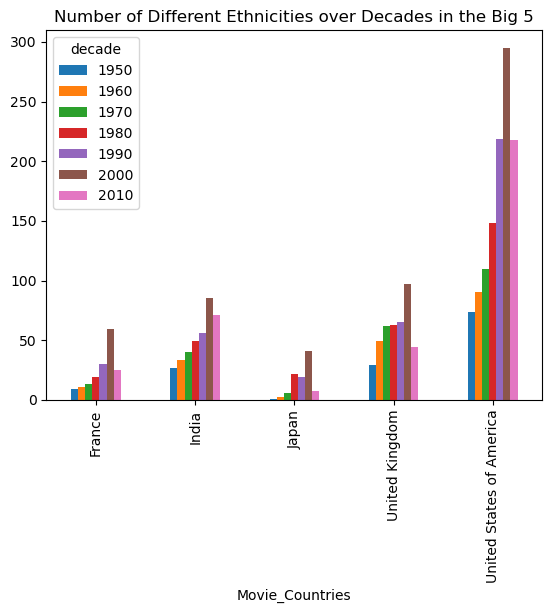

In [141]:
# plot number of ethnicities
count_ethnic.unstack().plot(kind='bar', title='Number of Different Ethnicities over Decades in the Big 5')

As we have more data about the US they also have more different ethnicities in total. We will therefore get a ratio.

In [148]:
# ratio number of unique / number of actors
ratio_u_t = char_ethnicity.groupby(['Movie_Countries', 'decade']).Actor_Ethnicity.nunique().div(char_ethnicity.groupby(['Movie_Countries', 'decade']).Actor_Ethnicity.count())

<AxesSubplot: title={'center': 'Ratio of Different Ethnicities Over Number of Actors in the Big 5'}, xlabel='Movie_Countries'>

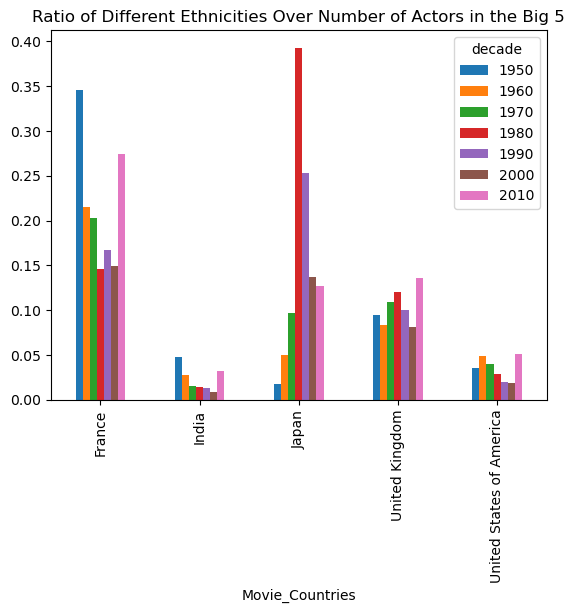

In [151]:
ratio_u_t.unstack().plot(kind='bar', title='Ratio of Different Ethnicities Over Number of Actors in the Big 5')

As in Asian countries the most representative ethnic group is supposedly Asians, we will examine the strongest ethnic groups in the countries.

As can be seen, there are still some inconsistencies in the assignment of ethnicities. There are e.g. 'white people' but also nationalities given, like 'French' or 'Italians'. Or 'Japanese people' but also 'Asian people' which should be a more abstract expression containing all ethnicities from Asia. This has to be accounted for when working with ethnicities.

In [231]:
# get the top 5 ethnicities from each of the big 5 movie industries
top_ethn = char_ethnicity.groupby('Movie_Countries').Actor_Ethnicity.value_counts()
top_ethn = top_ethn.groupby('Movie_Countries').nlargest(5).to_frame().droplevel(0)
top_ethn = top_ethn.rename(columns={'Actor_Ethnicity': 'Count'})
top_ethn

Count
Movie_Countries          Actor_Ethnicity         
France                   French               534
                         Jewish people         65
                         white people          30
                         Italians              27
                         /m/02p656s            22
India                    Indians            13822
                         Tamil               1007
                         Punjabis             939
                         Malayali             884
                         Marathi people       744
Japan                    Japanese people      476
                         Jewish people         19
                         Asian people          18
                         English people         9
                         African Americans      8
United Kingdom           English people      1592
                         Jewish people        417
                         British people       359
                         Scottish people      262
                         White British        242
United States of America African Americans   7969
                         Jewish people       6398
                         Irish Americans     2638
                         Italian Americans   2273
                         white Americans     1700

In [357]:
# get the total number of actors with data about information grouped by country
total_number = char_ethnicity.groupby('Movie_Countries').Actor_Ethnicity\
.count().to_frame().rename(columns={'Actor_Ethnicity': 'Count'})

In [355]:
top_perc = top_ethn.div(total_number).rename(columns={'Count': 'Fraction'})

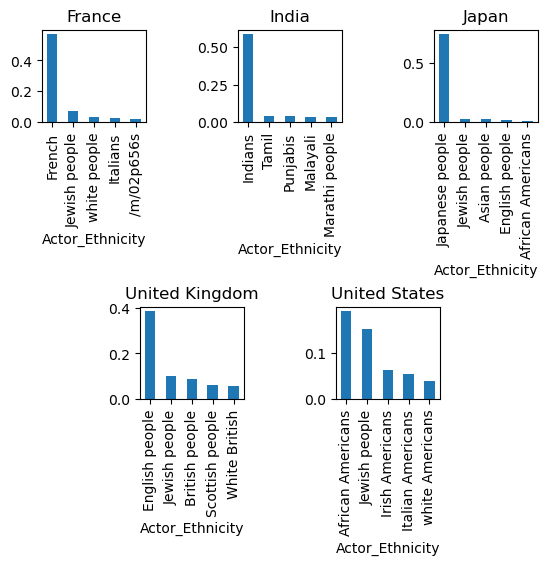

In [356]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

top_perc.loc['France'].plot(kind='bar', title='France', ax=ax1)
top_perc.loc['India'].plot(kind='bar', title='India', ax=ax2)
top_perc.loc['Japan'].plot(kind='bar', title='Japan', ax=ax3)
top_perc.loc['United Kingdom'].plot(kind='bar', title='United Kingdom', ax=ax4)
top_perc.loc['United States of America'].plot(kind='bar', title='United States', ax=ax5)

ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()
ax4.legend().remove()
ax5.legend().remove()

plt.subplots_adjust(hspace=2, wspace=15)

#### 3.2.4 Height

In [359]:
# assign to new variable
char_height = characters

In [360]:
no_nan_height = len(char_height[char_height.Actor_Height.isna()])
print(f"There are {no_nan_height} NaN values for the height of actors.")

There are 144382 NaN values for the height of actors.


In [361]:
# drop rows with missing values
char_height = char_height.dropna(subset='Actor_Height')

The maximum height of 510 m is impossible, therefore, there exist inconsistent data about the actor's height. The tallest person was 2.72 m. Therefore, we will filter out every actor above that height.

Source: https://en.wikipedia.org/wiki/Robert_Wadlow

In [362]:
# check statistics for inconsistencies
char_height.Actor_Height.describe()

count    100825.000000
mean          1.769042
std           2.885711
min           0.813000
25%           1.680000
50%           1.750000
75%           1.830000
max         510.000000
Name: Actor_Height, dtype: float64

In [363]:
# filter data
char_height = char_height[char_height.Actor_Height < 2.72]

For 8.1 % of the given actors we can analyze the height:

In [364]:
ncharacters_height = aggregate.ncharacters(char_height)
nactors_height = aggregate.nactors(char_height)
print(f'- Number of characters: {ncharacters_height} ({ncharacters_height / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors_height} ({nactors_height / nactors_raw:.1%})')

- Number of characters: 56941 (31.0%)
- Number of actors:     10975 (8.1%)


<AxesSubplot: title={'center': 'Actor_Height'}, xlabel='Movie_Countries'>

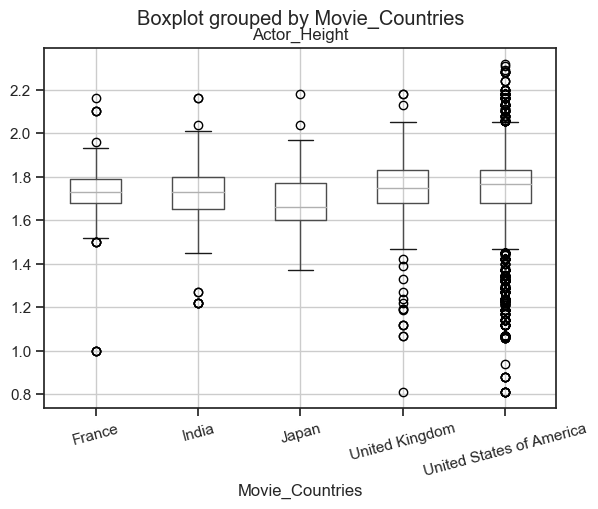

In [365]:
# plot data
char_height.boxplot(by='Movie_Countries', column='Actor_Height', rot=15)

C:\Users\Tim\AppData\Local\Temp\ipykernel_13784\1790738641.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=char_height, x="decade", y="Actor_Height", hue="Movie_Countries", ci=95)


<AxesSubplot: xlabel='decade', ylabel='Actor_Height'>

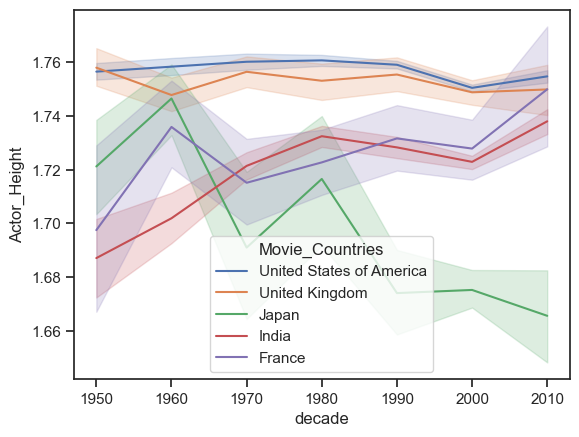

In [366]:
# check height over decades
# CI of 95 % was added
sns.lineplot(data=char_height, x="decade", y="Actor_Height", hue="Movie_Countries", ci=95)

As women are generally less tall than men, we will split the data into male and female.

In [367]:
# use gender as additional information
height_gender = pd.get_dummies(char_height, columns=['Actor_Gender'])

In [368]:
# assign data to male/female
female_height = height_gender[height_gender.Actor_Gender_F == 1]
male_height = height_gender[height_gender.Actor_Gender_M == 1]

To check for discrimination we need to compare the smallest and tallest persons during the decades. The average value does not give much information about that.

In [369]:
female_height.Actor_Height.describe()

count    36376.000000
mean         1.661554
std          0.068711
min          1.060000
25%          1.620000
50%          1.660000
75%          1.702000
max          2.010000
Name: Actor_Height, dtype: float64

In [370]:
male_height.Actor_Height.describe()

count    64349.000000
mean         1.800644
std          0.088822
min          0.813000
25%          1.750000
50%          1.800000
75%          1.850000
max          2.316480
Name: Actor_Height, dtype: float64

In [371]:
# get the min and max values
min_male_h = male_height.groupby(['Movie_Countries', 'decade']).min(numeric_only=True)
max_male_h = male_height.groupby(['Movie_Countries', 'decade']).max(numeric_only=True)
min_female_h = female_height.groupby(['Movie_Countries', 'decade']).min(numeric_only=True)
max_female_h = female_height.groupby(['Movie_Countries', 'decade']).max(numeric_only=True)

The UK and the USA had both very tall and short male actors over the time of 1950-2013. France and India started including very short male actors from the 2000's. Tall people were always part of movies, however, short men were not included in Japan. Short-grown women were not part of movies until the 80's.

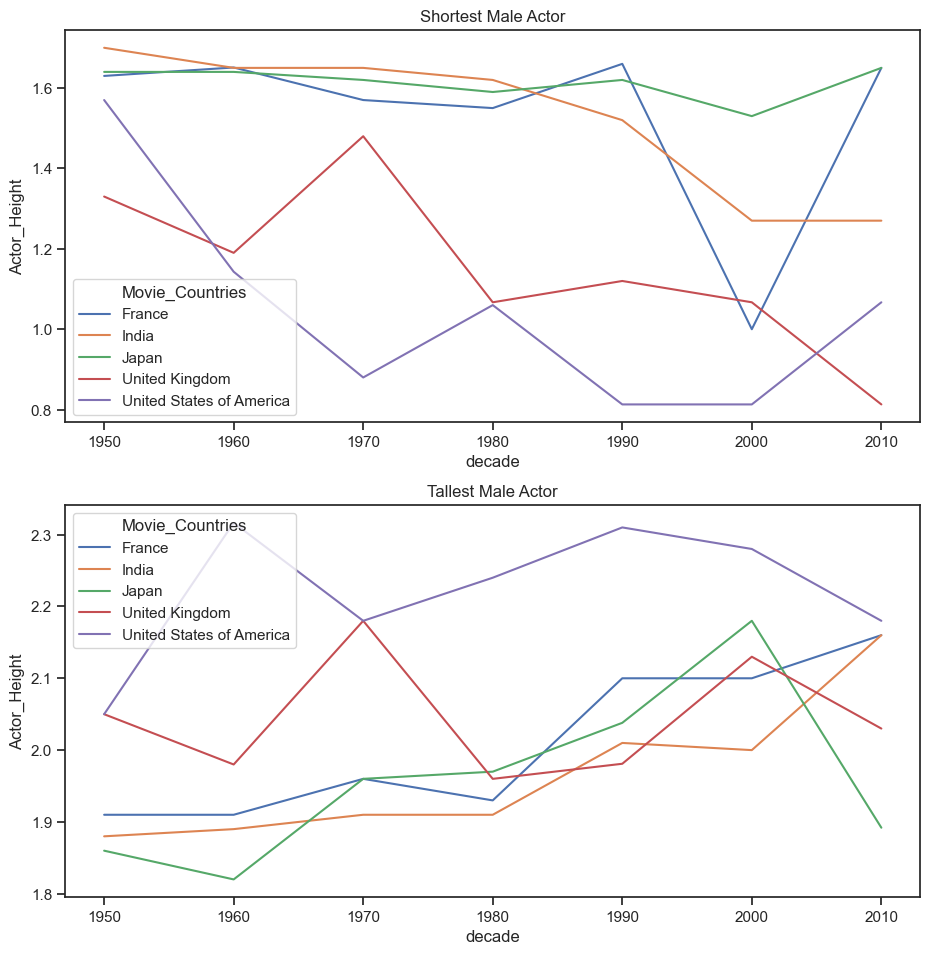

In [372]:
# check male height over decades
fig, ax = plt.subplots(2, figsize=(10,10))
plt.tight_layout(pad=3)
sns.set(style="ticks")
ax[0].set_title('Shortest Male Actor')
ax[1].set_title('Tallest Male Actor')
sns.lineplot(data=min_male_h, x="decade", y="Actor_Height", hue="Movie_Countries", ax=ax[0])
sns.lineplot(data=max_male_h, x="decade", y="Actor_Height", hue="Movie_Countries", ax=ax[1])
plt.show()

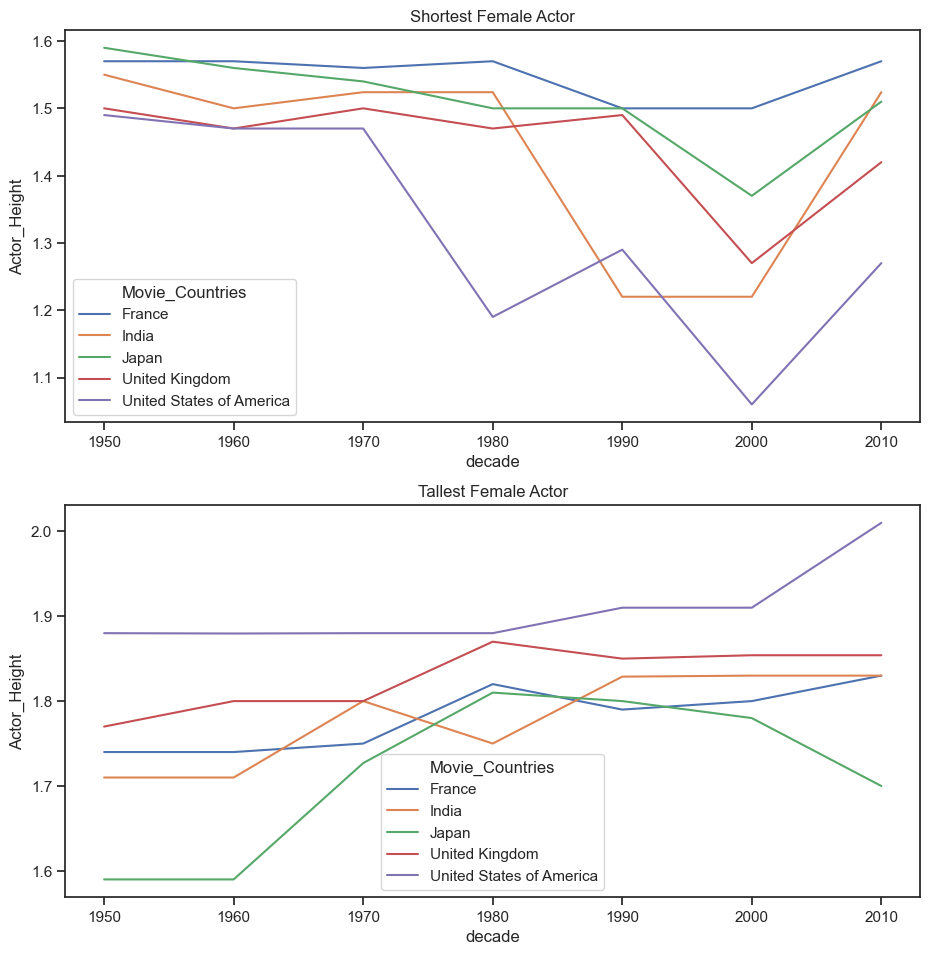

In [373]:
# check female height over decades
fig, ax = plt.subplots(2, figsize=(10,10))
plt.tight_layout(pad=3)
sns.set(style="ticks")
ax[0].set_title('Shortest Female Actor')
ax[1].set_title('Tallest Female Actor')
sns.lineplot(data=min_female_h, x="decade", y="Actor_Height", hue="Movie_Countries", ax=ax[0])
sns.lineplot(data=max_female_h, x="decade", y="Actor_Height", hue="Movie_Countries", ax=ax[1])
plt.show()

### 3.3 Success across industries

Our intial question, but now more precisely comparing across different countries.
What factors predict the success of a movie (financial and rating), and do they differ across the different countries?

We are interested in collecting other metadata to support our analysis. For this we harverst the imdb rating and we use for that imdb python api that seem to be more native and easier than through requests as the html location differ. The initial steps for how to perform it with beautiful soup will be as well showcased. 


In [142]:
# sample data where there is 10 movies for each country and decade
sample = movies.groupby(['Movie_Countries', 'decade']).apply(lambda x: x.sample(10))
#sample_movies = movies[['Movie_Name', 'Movie_Runtime', 'Movie_Countries', 'decade']].drop_duplicates().sample(100)

In [146]:
def get_rating(movie_name):
    """Get the rating of a movie from IMDB"""	
    # get the rating of a movie
    imdb_obj = imdb.IMDb()
    print(f"Searching for {movie_name}...")
    search = imdb_obj.search_movie(movie_name)  # search for the movie name in the imdb database 
    if len(search) == 0:
        print(f"Movie {movie_name} not found.")
        return None
    else:
        movie_id = search[0].getID()  # get the id of the first result
        imdb_url = 'http://www.imdb.com//title/tt'+ movie_id +'/' # create the url
        #response = requests.get(imdb_url) # get the response
        #soup = BeautifulSoup(response.text, "html.parser") # parse the response but it is easier to harvest the data using the api
        movie_meta = imdb_obj.get_movie(movie_id)
        if 'rating' in movie_meta.keys():
            rating = movie_meta['rating']
            print(f"Rating of {movie_name} is {rating}")
            return rating
        else:
            print(f"Rating of {movie_name} not found.")
            return None

In [147]:
# get the rating of the movies in the sample
sample['rating'] = sample.Movie_Name.apply(get_rating)

Searching for Two Men in Manhattan...
Rating of Two Men in Manhattan is 6.6
Searching for Night and Fog...
Movie Night and Fog not found.
Searching for Diary of a Country Priest...
Rating of Diary of a Country Priest is 7.8
Searching for Manèges...
Rating of Manèges is 7.2
Searching for Massacre in Lace...
Movie Massacre in Lace not found.
Searching for Casque d'or...
Rating of Casque d'or is 7.6
Searching for Afrique 50...
Rating of Afrique 50 is 7.2
Searching for Cyrano de Bergerac...
Rating of Cyrano de Bergerac is 7.5
Searching for La Ronde...
Movie La Ronde not found.
Searching for La Marie du port...
Movie La Marie du port not found.
Searching for The Smugglers...
Rating of The Smugglers is 6.2
Searching for Two or Three Things I Know About Her...
Movie Two or Three Things I Know About Her not found.
Searching for The Two of Us...
Rating of The Two of Us is 6.5
Searching for The Sleeping Car Murders...
Movie The Sleeping Car Murders not found.
Searching for La Jetée...
Movie La J

In [148]:
sample.head(10)

index  Wikipedia_Movie_ID Freebase_Movie_ID  \
Movie_Countries decade                                                       
France          1950   62702   28136            20789377        /m/057ch2s   
                       125394  56424            20181860         /m/017js3   
                       138110  62020            29831417         /m/086pyj   
                       78613   35415            28126186        /m/0cm9vqf   
                       155544  69735            29002980        /m/0dgq9xq   
                       6567     2986             3654133         /m/09sg_s   
                       5336     2435            35002603        /m/0j62n_g   
                       153357  68788             4432750         /m/0c22kf   
                       176492  78978             1923722         /m/066fb9   
                       129379  58156            25289332        /m/09gcybf   

                                              Movie_Name Movie_Release_Date  \
Movie_Countries decade                                                        
France          1950   62702        Two Men in Manhattan         1959-10-16   
                       125394              Night and Fog         1955-01-01   
                       138110  Diary of a Country Priest         1951-01-01   
                       78613                     Manèges         1950-01-25   
                       155544           Massacre in Lace         1952-03-12   
                       6567                  Casque d'or         1952-04-16   
                       5336                   Afrique 50         1950-01-01   
                       153357         Cyrano de Bergerac         1950-01-01   
                       176492                   La Ronde         1950-01-01   
                       129379           La Marie du port         1950-02-25   

                                 Revenue  Movie_Runtime   Movie_Languages  \
Movie_Countries decade                                                      
France          1950   62702         NaN           84.0   French Language   
                       125394        NaN           32.0   French Language   
                       138110        NaN          115.0   French Language   
                       78613         NaN           91.0   French Language   
                       155544        NaN           97.0   French Language   
                       6567          NaN           94.0   French Language   
                       5336          NaN           17.0   French Language   
                       153357  1900000.0          112.0  English Language   
                       176492        NaN           93.0   French Language   
                       129379        NaN          100.0   French Language   

                              Movie_Countries    Movie_Genres  year  decade  \
Movie_Countries decade                                                        
France          1950   62702           France        Thriller  1959    1950   
                       125394          France      Short Film  1955    1950   
                       138110          France         Mystery  1951    1950   
                       78613           France       Melodrama  1950    1950   
                       155544          France   Crime Fiction  1952    1950   
                       6567            France           Drama  1952    1950   
                       5336            France      Short Film  1950    1950   
                       153357          France           Drama  1950    1950   
                       176492          France  Romantic drama  1950    1950   
                       129379          France    Romance Film  1950    1950   

                               rating  
Movie_Countries decade                 
France          1950   62702      6.6  
                       125394     NaN  
                       138110     7.8  
                       78613      7.2  
                       155544  

In [155]:
# drop rows with missing values
sample = sample.dropna(subset=['rating'])


In [160]:
sample.describe()

,index,Wikipedia_Movie_ID,Revenue,Movie_Runtime,year,decade,rating
count,170.000000,1.700000e+02,2.200000e+01,146.000000,170.000000,170.000000,170.000000
mean,45324.311765,1.574861e+07,6.785821e+07,107.691781,1985.129412,1981.000000,6.410588
std,24391.698488,1.154283e+07,1.585666e+08,37.721039,19.776436,20.341755,1.133359
min,390.000000,1.792000e+04,1.900000e+06,17.000000,1950.000000,1950.000000,3.300000
25%,24072.000000,4.575240e+06,7.319495e+06,90.000000,1969.000000,1960.000000,5.700000
50%,51617.500000,1.486190e+07,2.254856e+07,102.000000,1987.000000,1980.000000,6.500000
75%,65159.750000,2.625152e+07,4.700489e+07,122.000000,2004.000000,2000.000000,7.200000
max,81306.000000,3.669992e+07,7.522166e+08,360.000000,2013.000000,2010.000000,8.600000


<AxesSubplot: >

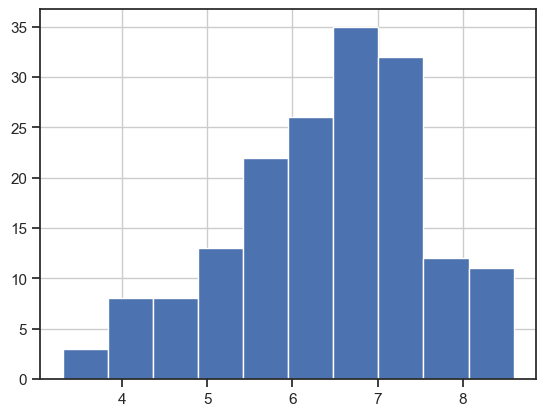

In [159]:
sample.rating.hist()

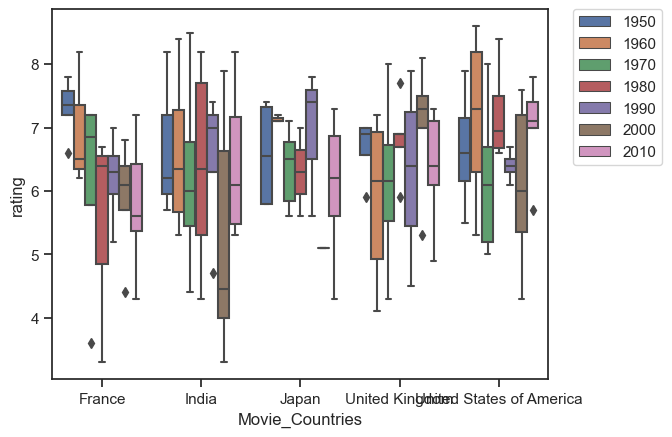

In [165]:
# plot data for specific countries
sns.boxplot(data=sample, x="Movie_Countries", y="rating", hue="decade")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


<AxesSubplot: xlabel='decade', ylabel='rating'>

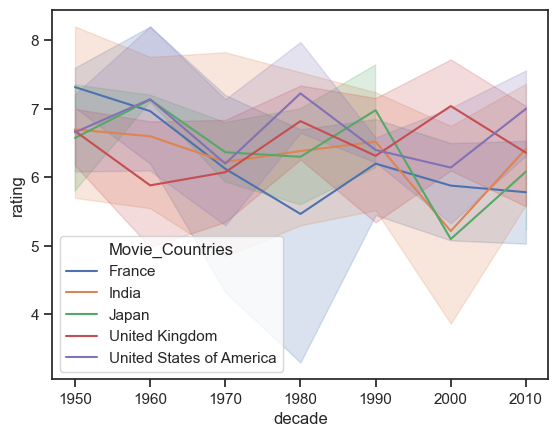

In [169]:
# plot rating over decades
sns.lineplot(data=sample, x="decade", y="rating", hue="Movie_Countries")